In [10]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRangePercentiles,
    ScaleIntensityRange,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    EnsureTyped,
    NormalizeIntensityd,
)
from monai.handlers.utils import from_engine
from monai.losses import GeneralizedDiceLoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm
import time

print_config()

MONAI version: 1.4.dev2415
Numpy version: 1.26.4
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 189d1865c1b5b228b9d9e5e95ed40969eda7badc
MONAI __file__: C:\Users\<username>\.conda\envs\nnUNet\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.1
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, pleas

In [11]:
directory = "demo_data2"
if not os.path.exists(directory):
    raise ValueError(f"Directory '{directory}' not found.")

In [12]:
train_images = sorted(glob.glob(os.path.join(directory, "imagesTr_cropped/train", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(directory, "labelsTr_cropped/train", "*.nii.gz")))
train_data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]


In [13]:
val_images = sorted(glob.glob(os.path.join(directory, "imagesTr_cropped/val", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(directory, "labelsTr_cropped/val", "*.nii.gz")))
val_data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]
val_data_dicts

[{'image': 'demo_data2\\imagesTr_cropped/val\\case_00002_0000.nii.gz',
  'label': 'demo_data2\\labelsTr_cropped/val\\case_00002.nii.gz'}]

In [14]:
set_determinism(seed=0)
performance_configs = {
    "train_patch_nums": 10,
    "CACHEDATASET_cache_rate": 1.0,
    "CACHEDATASET_num_workers": 4,
    "DATALOADER_batch_size": 2,
    "DATALOADER_num_workers": 4,
}

In [15]:

from monai.transforms import NormalizeIntensity

keys = ["image", "label"]

train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        EnsureTyped(keys=keys),
        Spacingd(keys=keys, pixdim=(1, 0.78, 0.78), mode=("bilinear", "nearest")),
        Orientationd(keys=keys, axcodes="RAS"),
        # 自动标准化：减去均值，除以标准差
        NormalizeIntensityd(keys="image"),
        CropForegroundd(keys=keys, source_key="image"),
        RandCropByPosNegLabeld(
            keys=keys, label_key="label", spatial_size=(128, 128, 128), pos=1, neg=1,
            num_samples=performance_configs["train_patch_nums"]
        ),

        # TODO：数据增强
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        EnsureTyped(keys=keys),
        Spacingd(keys=keys, pixdim=(1, 0.78, 0.78), mode=("bilinear", "nearest")),
        Orientationd(keys=keys, axcodes="RAS"),
        NormalizeIntensityd(keys="image"),
        CropForegroundd(keys=keys, source_key="image"),

        # TODO： 数据增强
    ]
)

In [16]:

check_ds = CacheDataset(data=val_data_dicts, transform=val_transforms,
                        cache_rate=performance_configs["CACHEDATASET_cache_rate"],
                        num_workers=performance_configs["CACHEDATASET_num_workers"])
check_loader = DataLoader(check_ds, batch_size=performance_configs["DATALOADER_batch_size"],
                          num_workers=performance_configs["DATALOADER_num_workers"])


Loading dataset: 100%|██████████| 1/1 [00:15<00:00, 15.80s/it]


# 查看数据

image shape: torch.Size([533, 447, 261]), label shape: torch.Size([533, 447, 261])


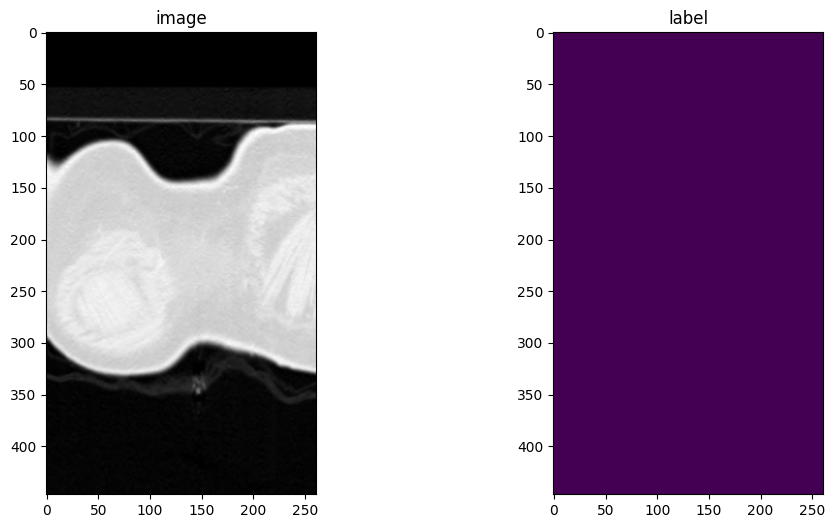

In [17]:
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[60, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[60, :, :])
plt.show()

In [18]:
# 计时

start = time.time()
train_ds = CacheDataset(data=train_data_dicts, transform=train_transforms,
                        cache_rate=performance_configs["CACHEDATASET_cache_rate"],
                        num_workers=performance_configs["CACHEDATASET_num_workers"])
train_loader = DataLoader(train_ds, batch_size=performance_configs["DATALOADER_batch_size"],
                          shuffle=True, num_workers=performance_configs["DATALOADER_num_workers"])

end = time.time()
print(f"Load Train Data Time: {end - start}")

val_ds = CacheDataset(data=val_data_dicts, transform=val_transforms,
                      cache_rate=performance_configs["CACHEDATASET_cache_rate"],
                      num_workers=performance_configs["CACHEDATASET_num_workers"])
val_loader = DataLoader(val_ds, batch_size=1, num_workers=performance_configs["DATALOADER_num_workers"])

end2 = time.time()
print(f"Load Val Data Time: {end2 - end}")

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Load Train Data Time: 1.6883459091186523


Loading dataset: 100%|██████████| 1/1 [00:17<00:00, 17.49s/it]

Load Val Data Time: 17.500954627990723


# Create Model, Loss, Optimizer

In [23]:
# 如果有GPU，使用GPU，否则使用CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(
    spatial_dims=3,  # 3D 图像分割 - 所以是 3
    in_channels=1,  # 输入通道数 
    out_channels=3,  # 包括背景 有 3 个类别
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
model

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [24]:
loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [25]:
max_epochs = 3
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
# 后处理
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=3)])
post_label = Compose([AsDiscrete(to_onehot=3)])

In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    start = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                # When roi_size is larger than the inputs' spatial size, the input image are padded during inference.
                # To maintain the same spatial sizes, the output image will be cropped to the original input size.
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result - aggregate() is
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(directory, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    end = time.time()
    print(f"spend time: {end - start}")

----------
epoch 1/3


In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join(directory, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, 180, :, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, 180, :, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 180, :, :])
        plt.show()
        if i == 2:
            break

# Evaluation on original image spacings

In [ ]:
val_orig_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        EnsureTyped(keys=keys),
        Spacingd(keys="image", pixdim=(1, 0.78, 0.78), mode="bilinear"),
        Orientationd(keys="image", axcodes="RAS"),
        NormalizeIntensityd(keys="image"),
        CropForegroundd(keys="image", source_key="image"),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_orig_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=3),
        AsDiscreted(keys="label", to_onehot=3),
    ]
)

In [ ]:

model.load_state_dict(torch.load(os.path.join(directory, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in tqdm(val_loader):
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        print(len(val_outputs), len(val_labels))
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)